# Polymer Chemistry Informed Neural Networks (PCINNs)

**Paper:** Ballard, N. *Polymer Chemistry Informed Neural Networks.* *Polym. Chem.*, 2024. DOI: [10.1039/D4PY00995A](https://doi.org/10.1039/D4PY00995A)

**GitHub:** [PolymatGIQ/PCINN](https://github.com/PolymatGIQ/PCINN)

This notebook implements the PCINN method for predicting methyl methacrylate (MMA) free-radical polymerization outcomes. The approach combines a data-driven neural network with Jacobian-based regularization from a pretrained kinetic ("theory") model. The theory model provides gradient information that guides the trainable network toward physically consistent predictions, yielding improved generalization compared to a purely data-driven baseline.

In [1]:
# Install pinned dependencies (verified compatible as of February 2026).
# On systems with CUDA, follow https://pytorch.org/get-started/locally/
# to install the CUDA-enabled PyTorch build instead of the default CPU-only wheel.
# If a pin fails to resolve, check PyPI for the latest patch in the same minor
# series (e.g., numpy==2.4.3 if 2.4.2 is superseded).
%pip install torch==2.10.0 numpy==2.4.2 pandas==2.2.3 matplotlib==3.10.8 openpyxl==3.1.5 "ipykernel>=6.29,<7"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.func import vmap, jacrev

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Model Definitions

Two neural network architectures are used. **`NNmodel`** is the trainable predictive network (5 inputs → 128 → 64 → 6 outputs, tanh activations) used for both the baseline and PCINN experiments. **`DomainModel`** is the pretrained theory surrogate (5 → 128 → 128 → 64 with split output heads: sigmoid for conversion, softplus for molecular weights) that provides Jacobian targets during PCINN training. See paper Scheme 2 (theory model) and Scheme 3 (PCINN architecture).

In [3]:
class NNmodel(nn.Module):  # Main network
    def __init__(self):
        super(NNmodel, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 6)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class DomainModel(nn.Module):  # "Theory network"
    def __init__(self):
        super(DomainModel, self).__init__()
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.Xout = nn.Linear(64, 1)
        self.Mout = nn.Linear(64, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        X_out = torch.sigmoid(self.Xout(x))  # conversion
        M_out = F.softplus(self.Mout(x))  # Mn, Mw, Mz, Mz+1, Mv

        return torch.cat((X_out, M_out), dim=-1)

## Data Preprocessing

Input features are scaled to the [0, 1] range using precomputed per-feature min and max values stored in `scalerx_min.npy` and `scalerx_max.npy`. The five molecular weight outputs (Mn, Mw, Mz, Mz+1, Mv) are log10-transformed before training to reduce scale differences, while conversion (X) is left on its original scale.

In [4]:
def scalefeaturezeroone(x, scalerxmax, scalerxmin):
    max_minus_min = (scalerxmax - scalerxmin)
    return (x - scalerxmin) / max_minus_min

In [5]:
scalerx_max = np.load('scalerx_max.npy')
scalerx_min = np.load('scalerx_min.npy')

# load training data
df = pd.read_excel('PMMAordered.xlsx')

dfX = df[["[M]", "[S]", "[I]", "temp", "time", "Reaction"]]
dfY = df[["X", "Mn", "Mw", "Mz", "Mzplus1", "Mv"]]

Xdata = dfX.values
Ydata = dfY.values

Ydata[:, 1:] = np.log10(Ydata[:, 1:])
Xdata[:, :5] = scalefeaturezeroone(Xdata[:, :5], scalerx_max, scalerx_min)

dfGPC = df.iloc[:, 18:]
GPCdata = dfGPC.values

Domain_NN = DomainModel()
import pickle
import _pickle

try:
    # Secure path first (PyTorch 2.6+ default).
    Domain_NN.load_state_dict(torch.load('MMA_solution_net.pt', weights_only=True))
except (pickle.UnpicklingError, _pickle.UnpicklingError):
    # Fallback for older pickle-based checkpoints; safe here because
    # this repository controls the checkpoint provenance.
    Domain_NN.load_state_dict(torch.load('MMA_solution_net.pt', weights_only=False))


## Jacobian Sampling Configuration

During PCINN training, 32 random points are sampled per epoch from the physical domain to compute Jacobian matching loss. The sampling ranges correspond to experimentally relevant conditions: temperature 323–363 K (50–90 °C), monomer concentration [M] 0.5–5 mol/L, initiator concentration [I] 0.005–0.1 mol/L, and reaction time 300–36,000 s (5 min to 10 hours). See paper eqn (9) for the combined loss function.

In [6]:
Tupper = 273 + 90
Tlower = 273 + 50

Mupper = 5
Mlower = 0.5

Iupper = 0.1
Ilower = 0.005

timeupper = 10 * 60 * 60
timelower = 5 * 60

M_sampler = torch.distributions.Uniform(low=Mlower, high=Mupper)
T_sampler = torch.distributions.Uniform(low=Tlower, high=Tupper)
I_sampler = torch.distributions.Uniform(low=Ilower, high=Iupper)
time_sampler = torch.distributions.Uniform(low=timelower, high=timeupper)

## Training Configuration

A leave-one-experiment-out cross-validation strategy is used: the dataset contains 8 distinct polymerization reactions, and `TestReaction` selects which reaction is held out for testing while the remaining 7 are used for training. To reproduce the full cross-validation results from paper Table 3, run this notebook 8 times with `TestReaction` set to each value from 1 to 8.

In [7]:
TestReaction = 8  # Integer between 1 and 8. Picks reaction that will be tested on (other reactions for training)

# get training samples
Xtrainsample = Xdata[Xdata[:, 5] != TestReaction]
Xtrainsample = Xtrainsample[:, :5]
Xtrainsample = torch.from_numpy(Xtrainsample).float()
Ytrainsample = Ydata[Xdata[:, 5] != TestReaction]
Ytrainsample = torch.from_numpy(Ytrainsample).float()

# get test samples
Xtestsample = Xdata[Xdata[:, 5] == TestReaction]
Xtestsample = Xtestsample[:, :5]
Xtestsample = torch.from_numpy(Xtestsample).float()
Ytestsample = Ydata[Xdata[:, 5] == TestReaction]

## Baseline Neural Network Training

This cell trains a conventional data-only neural network (no Jacobian regularization) as a control comparison. The model is trained for 10,000 epochs with Adam (lr=3e-4) and MSE loss on the training data only. This serves as the baseline against which the PCINN is compared in paper Table 3.

C:\Users\Ari\AppData\Local\Temp\ipykernel_13372\2169113717.py:21: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  reg_losses.append(float(Sum_Obj_loss))


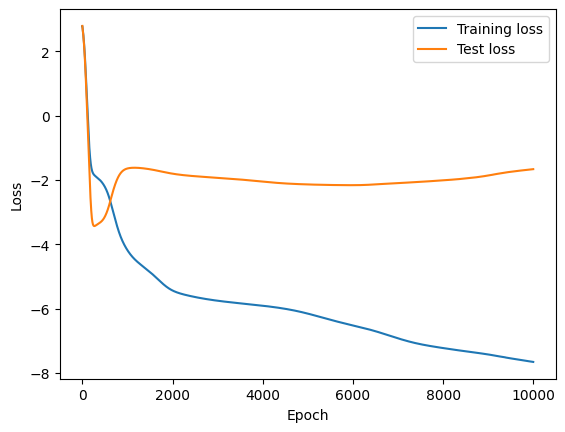

In [8]:
model = NNmodel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3E-4)

epochs = 10000
reg_losses = []
reg_losses_test = []
for epoch in range(epochs):
    Sum_Obj_loss = 0
    pred = model(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)
    Sum_Obj_loss += trainloss
    if epoch >= 1:
        # Backpropagation
        trainloss.backward()
        optimizer.step()
        optimizer.zero_grad()

    pred = model(Xtestsample)
    testloss = loss_function(pred, torch.from_numpy(Ytestsample).float())
    reg_losses.append(float(Sum_Obj_loss))
    reg_losses_test.append(float(testloss))

NNpred = model(Xtestsample)

plt.plot(np.log(reg_losses), label='Training loss')
plt.plot(np.log(reg_losses_test), label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## PCINN Training

The PCINN augments the standard data-driven MSE loss with a Jacobian matching term (see paper eqn 9). At each epoch, 32 random points are sampled from the physical domain and the Jacobian of both the trainable network and the pretrained theory network are computed using `vmap(jacrev(...))`. The MSE between these Jacobians is added to the data loss, encouraging the PCINN to learn input-output sensitivities consistent with the underlying kinetic model.

C:\Users\Ari\AppData\Local\Temp\ipykernel_13372\1273216131.py:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sampl = (sampl - scalerx_min) / (scalerx_max - scalerx_min)


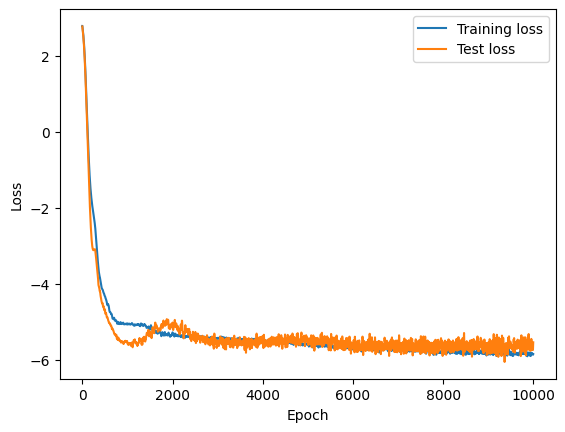

In [9]:
PCINNmodel = NNmodel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(PCINNmodel.parameters(), lr=3E-4)

epochs = 10000

reg_losses = []
reg_losses_test = []

totaljacsamples = 32

for epoch in range(epochs):
    Sum_Jac_loss = 0
    Sum_Obj_loss = 0

    pred = PCINNmodel(Xtrainsample)
    trainloss = loss_function(pred, Ytrainsample)
    Sum_Obj_loss += trainloss

    Msample = M_sampler.sample((32, 1))
    Ssample = 10 - Msample
    Isample = I_sampler.sample((32, 1))
    Tsample = T_sampler.sample((32, 1))
    tsample = time_sampler.sample((32, 1))
    sampl = torch.cat((Msample, Ssample, Isample, Tsample, tsample), 1)
    sampl = (sampl - scalerx_min) / (scalerx_max - scalerx_min)

    jac_theory_sampl = vmap(jacrev(Domain_NN))(sampl.float())
    jac_sampl = vmap(jacrev(PCINNmodel))(sampl.float())

    jacloss = loss_function(jac_sampl, jac_theory_sampl)
    Sum_Jac_loss += jacloss

    loss = trainloss + jacloss

    if epoch >= 1:
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    reg_losses.append(float(Sum_Obj_loss))
    pred = PCINNmodel(Xtestsample)
    testloss = loss_function(pred, torch.from_numpy(Ytestsample).float())
    reg_losses_test.append(float(testloss))

EBNNpred = PCINNmodel(Xtestsample)

plt.plot(np.log(reg_losses), label='Training loss')
plt.plot(np.log(reg_losses_test), label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Results Summary

Compare the train/test loss curves from both models above. The PCINN should show lower test loss than the baseline NN, demonstrating that Jacobian regularization from the theory model improves generalization. To reproduce the full leave-one-experiment-out cross-validation results from paper Table 3, re-run this notebook with `TestReaction` set to each integer from 1 to 8 and aggregate the per-reaction test errors.